In [1]:
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
#from xgboost import XGBRegressor
import math
from sklearn.metrics import mean_squared_error

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Importing Building Meta Data into Pandas DataFrame

In [4]:
#path = r'/content/drive/My Drive/case study1/building_metadata.csv'
building_data = pd.read_csv('building_metadata.csv')
building_data.head()

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,NaN
1,0,1,Education,2720,2004.0,NaN
2,0,2,Education,5376,1991.0,NaN
3,0,3,Education,23685,2002.0,NaN
4,0,4,Education,116607,1975.0,NaN


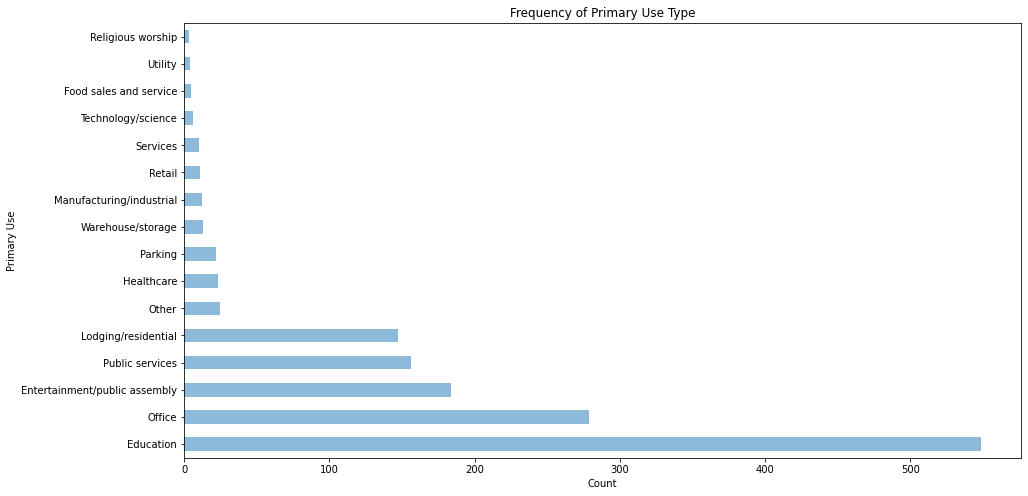

In [4]:
plt.rcParams['figure.figsize']=(15,8)
building_data.primary_use.value_counts().plot(kind='barh',alpha=0.5)
plt.xlabel('Count')
plt.ylabel('Primary Use')
plt.title('Frequency of Primary Use Type')
plt.show()

'Education' Building Primary Use Type is having the largest count which may lead to most energy consumption

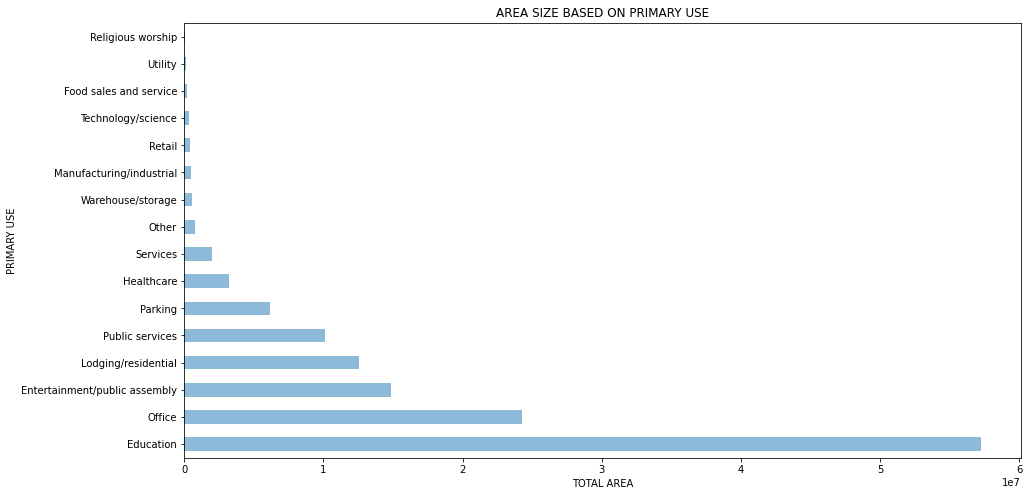

In [5]:
plt.rcParams['figure.figsize']=(15,8)
building_data.groupby('primary_use')['square_feet'].sum().sort_values(ascending=False).plot(kind='barh',alpha=0.5)
plt.xlabel('TOTAL AREA')
plt.ylabel('PRIMARY USE')
plt.title('AREA SIZE BASED ON PRIMARY USE')
plt.show()

'Education' Primary Use is having maximum square feet area which may lead to maximum energy consumption

#Importing weather_train Data into Pandas Dataframe

In [5]:
#path = r'/content/drive/My Drive/case study1/weather_train.csv'
weather = pd.read_csv('weather_train.csv')
weather.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,0,2016-01-01 01:00:00,24.4,NaN,21.1,-1.0,1020.2,70.0,1.5
2,0,2016-01-01 02:00:00,22.8,2.0,21.1,0.0,1020.2,0.0,0.0
3,0,2016-01-01 03:00:00,21.1,2.0,20.6,0.0,1020.1,0.0,0.0
4,0,2016-01-01 04:00:00,20.0,2.0,20.0,-1.0,1020.0,250.0,2.6


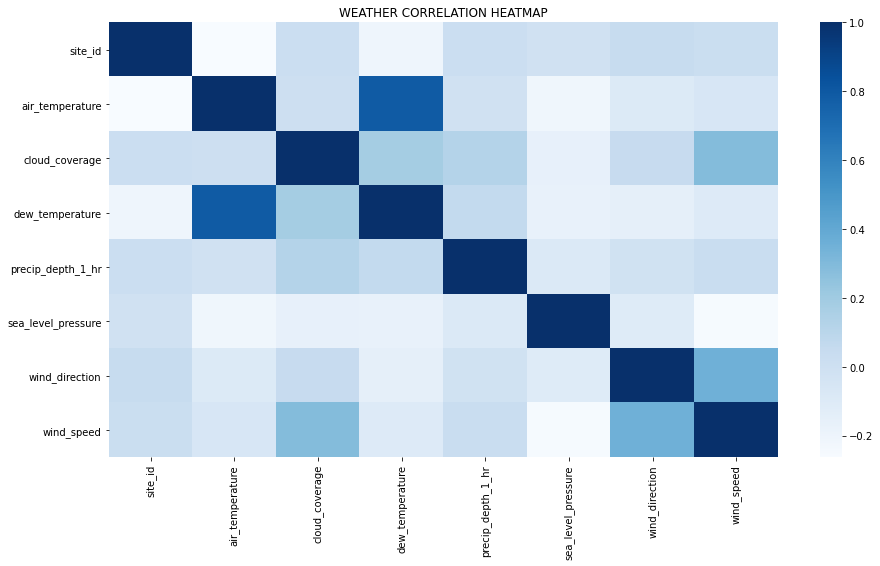

In [7]:
sns.heatmap(weather.corr(),cmap='Blues')
plt.title('WEATHER CORRELATION HEATMAP')
plt.show()

Air_temparature and dew_temparature features are highly correlated and sea_level_pressure is having less relation with other features

#Importing Train Data into Pandas Dataframe

In [6]:
#path = r'/content/drive/My Drive/case study1/train.csv'
train = pd.read_csv('train.csv')
train.head()

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01 00:00:00,0.0
1,1,0,2016-01-01 00:00:00,0.0
2,2,0,2016-01-01 00:00:00,0.0
3,3,0,2016-01-01 00:00:00,0.0
4,4,0,2016-01-01 00:00:00,0.0


# Merge traindata , building data and weather data

In [7]:
new=pd.merge(train,building_data,how="left",on='building_id')
train_data=pd.merge(new,weather,how="left",on=['site_id','timestamp'])
train_data.head()


,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,2016-01-01 00:00:00,0.0,0,Education,7432,2008.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,1,0,2016-01-01 00:00:00,0.0,0,Education,2720,2004.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
2,2,0,2016-01-01 00:00:00,0.0,0,Education,5376,1991.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
3,3,0,2016-01-01 00:00:00,0.0,0,Education,23685,2002.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
4,4,0,2016-01-01 00:00:00,0.0,0,Education,116607,1975.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0


#FEATURE ENGINEERING

In [8]:
'''make a copy of train data and add features'''
train_copy = train_data.copy()

In [11]:
'''Dropping Timestamp and extracting other features from timestamp'''
train_copy.drop(columns=['timestamp'],inplace=True,axis=1)

In [9]:
''' add new features'''
train_copy['timestamp']=pd.to_datetime(train_copy['timestamp'])
train_copy['hour']=np.uint8(train_copy['timestamp'].dt.hour)
train_copy['day']=np.uint8(train_copy['timestamp'].dt.day)
train_copy['month']=np.uint8(train_copy['timestamp'].dt.month)
train_copy['weekday']=np.uint8(train_copy['timestamp'].dt.dayofweek)
''' change the datatype to reduce memory usage'''
train_copy['building_id']=np.uint8(train_copy['building_id'])
train_copy['meter']=np.uint8(train_copy['meter'])
train_copy['site_id']=np.uint8(train_copy['site_id'])
train_copy['square_feet']=np.uint8(train_copy['square_feet'])
'''train_copy['floor_count']=np.uint8(train_data['floor_count'])
train_copy['air_temperature']=np.float32(train_data['air_temperature'])
train_copy['cloud_coverage']=np.float32(train_data['cloud_coverage'])
train_copy['dew_temperature']=np.float16(train_data['dew_temperature'])
train_copy['precip_depth_1_hr']=np.float16(train_data['precip_depth_1_hr'])
train_copy['sea_level_pressure']=np.float16(train_data['sea_level_pressure'])
train_copy['wind_direction']=np.float16(train_data['wind_direction'])
train_copy['wind_speed']=np.float16(train_data['wind_speed'])'''
train_copy.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,hour,day,month,weekday
0,0,0,2016-01-01,0.0,0,Education,8,2008.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0,0,1,1,4
1,1,0,2016-01-01,0.0,0,Education,160,2004.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0,0,1,1,4
2,2,0,2016-01-01,0.0,0,Education,0,1991.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0,0,1,1,4
3,3,0,2016-01-01,0.0,0,Education,133,2002.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0,0,1,1,4
4,4,0,2016-01-01,0.0,0,Education,127,1975.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0,0,1,1,4


1. Add column named ‘ hour’
2. Add column named ‘ day’
3. Add column named ‘ month’
4. Add column named ‘ weekday

Here we reduce the size of datatype of few features for better memory optimization

In [10]:
def daymap(x):
  day_dict={0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'}
  return day_dict[x]

In [11]:
train_copy['weekday']= train_copy['weekday'].map(daymap)

In [12]:
train_copy.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,hour,day,month,weekday
0,0,0,2016-01-01,0.0,0,Education,8,2008.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0,0,1,1,Friday
1,1,0,2016-01-01,0.0,0,Education,160,2004.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0,0,1,1,Friday
2,2,0,2016-01-01,0.0,0,Education,0,1991.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0,0,1,1,Friday
3,3,0,2016-01-01,0.0,0,Education,133,2002.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0,0,1,1,Friday
4,4,0,2016-01-01,0.0,0,Education,127,1975.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0,0,1,1,Friday


# EDA

In [17]:
''' To see how many types of meter is there in the data set'''
sorted(list(train.meter.unique()))

[0, 1, 2, 3]

There are 4 types of meter in the dataset

In [18]:
''' to see how many data is there for each meter type'''
train.meter.value_counts()

0    12060910
1     4182440
2     2708713
3     1264037
Name: meter, dtype: int64

From above , we can say there are 12060910 reading for meter type 0 ,4182440 for meter type 1,2708713 for meter type 2 and 1264037 meter type 3.

In [19]:
''' To see which reading is coming how much time in total data set'''
train.meter_reading.value_counts()

0.0000       1873976
20.0000        23363
2.9307         23181
36.6000        22154
8.7921         21787
              ...   
72.6357            1
2977.7000          1
55.4186            1
2977.4500          1
15.3563            1
Name: meter_reading, Length: 1688175, dtype: int64

From the above data we can say 0 reading is coming  1873976 times all over the data.

In [20]:
'''To see the total time period through which data has been collected'''
train.timestamp.min(),train.timestamp.max()

('2016-01-01 00:00:00', '2016-12-31 23:00:00')

In [13]:
''' change the meter reading as per meter type'''
def meterclass(x):
  train_dict = {0:'Electricity',1:'chiledWater',2:'Steam',3:'HotWater'}
  return(train_dict[x])

In [14]:
'''  above change has been done'''

train_copy['meter']=train_copy.meter.map(meterclass)

In [15]:
train_copy.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,hour,day,month,weekday
0,0,Electricity,2016-01-01,0.0,0,Education,8,2008.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0,0,1,1,Friday
1,1,Electricity,2016-01-01,0.0,0,Education,160,2004.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0,0,1,1,Friday
2,2,Electricity,2016-01-01,0.0,0,Education,0,1991.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0,0,1,1,Friday
3,3,Electricity,2016-01-01,0.0,0,Education,133,2002.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0,0,1,1,Friday
4,4,Electricity,2016-01-01,0.0,0,Education,127,1975.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0,0,1,1,Friday


In [16]:
'''Identifying Unique Meter Type'''
train_copy.meter.unique()

array(['Electricity', 'HotWater', 'chiledWater', 'Steam'], dtype=object)

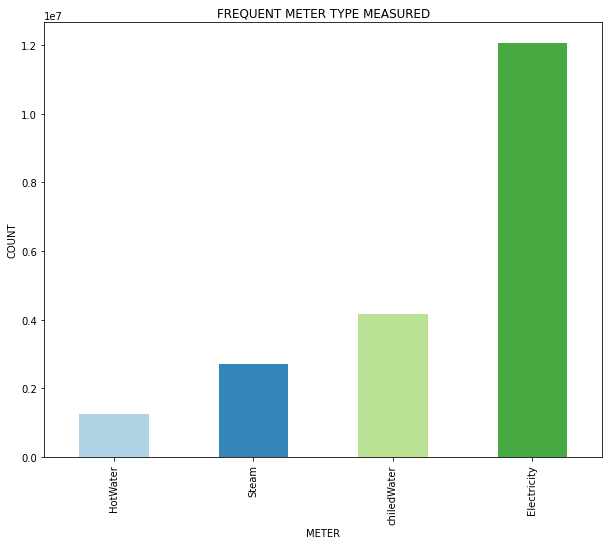

In [25]:
''' To see the reading has been taken most frequently to which meter'''
plt.rcParams['figure.figsize']=(10,8)
train_copy.meter.value_counts().sort_values(ascending=True).plot(kind='bar',alpha=0.9,color=plt.cm.Paired(np.arange(len(train_copy.meter.unique()))))
plt.xlabel('METER')
plt.ylabel('COUNT')
plt.title('FREQUENT METER TYPE MEASURED')
plt.show()

From the above graph we can conclude the meter reading has been taken most frequently from Electricity meter type. Very less reading has been taken from Hotwater meter type

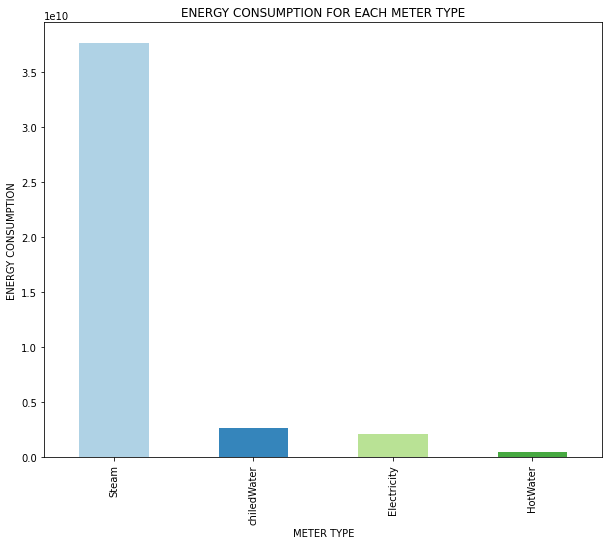

In [26]:
''' to see the total energy consumption per meter type'''
train_copy.groupby('meter')['meter_reading'].sum().sort_values(ascending = False).plot(kind='bar',alpha=0.9,color=plt.cm.Paired(np.arange(len(train.meter.unique()))))
plt.xlabel('METER TYPE')
plt.ylabel('ENERGY CONSUMPTION')
plt.title('ENERGY CONSUMPTION FOR EACH METER TYPE')
plt.show()

From the above graph we can conclude, maximum energy consumption has been done due to steam and very less energy consumed for hotwater. The total energy consumption due te chiiled water and electricy is very close. 

In [17]:
''' mean meter reading through out the week'''
train_copy.groupby('weekday')['meter_reading'].mean().sort_values(ascending = False)

weekday
Wednesday    2485.819959
Tuesday      2267.786315
Thursday     2263.206170
Friday       2151.439219
Monday       1967.816997
Saturday     1865.434390
Sunday       1820.957143
Name: meter_reading, dtype: float64

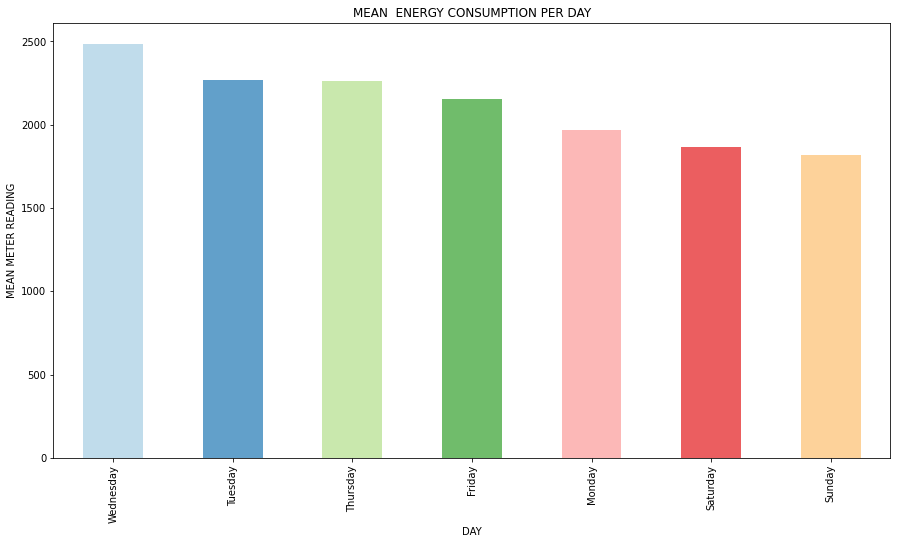

In [34]:
''' to see the energy consumption per day '''
plt.rcParams['figure.figsize']=(15,8)
train_copy.groupby('weekday')['meter_reading'].mean().sort_values(ascending = False).plot(kind='bar',alpha=0.7,color=plt.cm.Paired(np.arange(len(train_copy.weekday.unique()))))
plt.title('MEAN  ENERGY CONSUMPTION PER DAY')
plt.xlabel('DAY')
plt.ylabel('MEAN METER READING')
plt.show()

This graph is showing mean meter reading distribution through out the week. Here we can see max energy consumption has happened in the middle of the week (Wednesday,Tuesday,Thursday). In weekend, the energy consumption is very less.

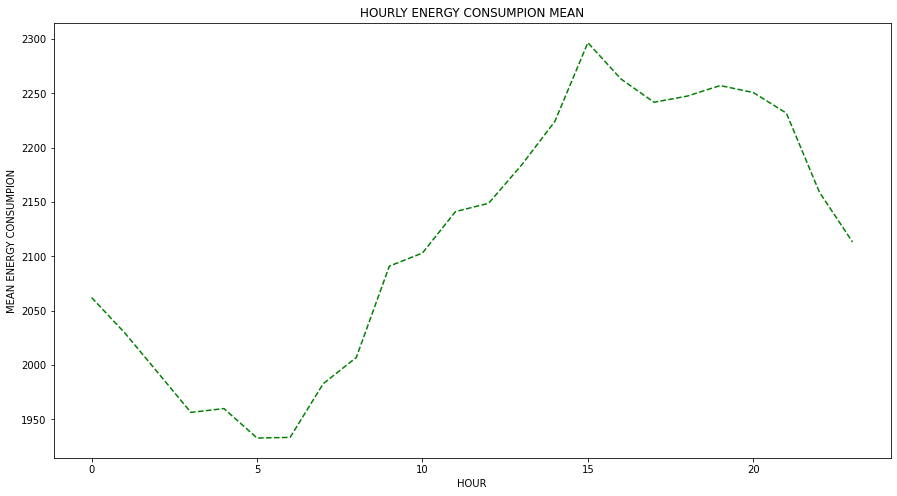

In [36]:
'''energy distribution for each hour in a day'''
plt.plot(train_copy.groupby('hour')['meter_reading'].mean(),color='green',linestyle='--')
plt.xlabel('HOUR')
plt.ylabel('MEAN ENERGY CONSUMPION')
plt.title('HOURLY ENERGY CONSUMPION MEAN')
plt.show()

This graph is basically showing the energy consumption through out the day. From here we can colclude, maximum energy consumption has happend in the middile of the day

In [37]:
train_copy['month'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12], dtype=uint8)

In [18]:
''' replace the month type with the month name'''
month={1:'Jan',2:'Feb',3:'March',4:'April',5:'May',6:'June',7:'July',8:'Aug',9:'Sept',10:'Oct',11:'Nov',12:'Dec'}
train_copy['month']=train_copy['month'].map(month)
train_copy.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,hour,day,month,weekday
0,0,Electricity,2016-01-01,0.0,0,Education,8,2008.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0,0,1,Jan,Friday
1,1,Electricity,2016-01-01,0.0,0,Education,160,2004.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0,0,1,Jan,Friday
2,2,Electricity,2016-01-01,0.0,0,Education,0,1991.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0,0,1,Jan,Friday
3,3,Electricity,2016-01-01,0.0,0,Education,133,2002.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0,0,1,Jan,Friday
4,4,Electricity,2016-01-01,0.0,0,Education,127,1975.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0,0,1,Jan,Friday


In [39]:
''' Mean energy consumption per month'''
train_copy.groupby('month')['meter_reading'].mean()

month
April    5566.060718
Aug       480.156512
Dec       530.556852
Feb      1208.032126
Jan      1150.157976
July      459.943558
June     4152.447422
March    4897.649796
May      5183.869585
Nov       850.654497
Oct       470.613136
Sept      633.044311
Name: meter_reading, dtype: float64

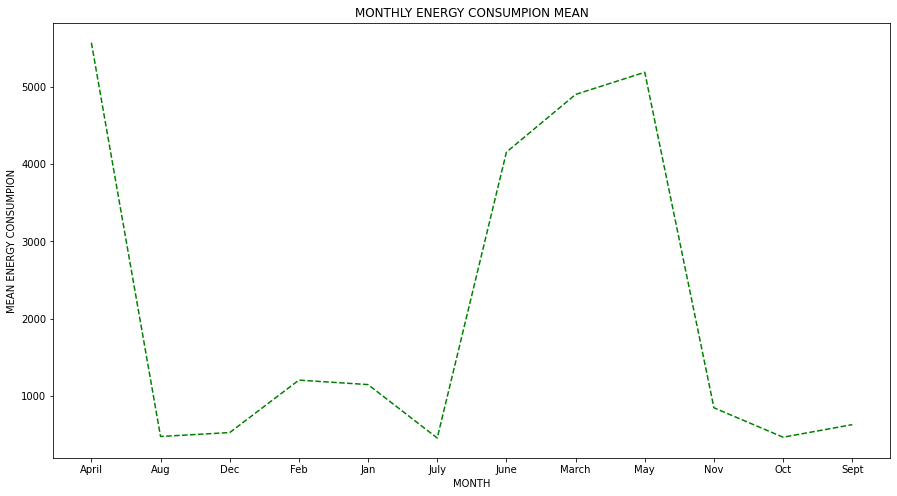

In [40]:
plt.plot(train_copy.groupby('month')['meter_reading'].mean(),color='green',linestyle='--')
plt.xlabel('MONTH')
plt.ylabel('MEAN ENERGY CONSUMPION')
plt.title('MONTHLY ENERGY CONSUMPION MEAN')
plt.show()

From here we can see that the max energy consumption has happend in between April to july

In [41]:
value = train_copy.groupby(['meter','month'])['meter_reading'].mean()

In [42]:
'''Mean monthly energy consumption per meter type(electricity,hot water, steam, chilled water)'''
value.unstack().style.background_gradient(axis = None)

month,April,Aug,Dec,Feb,Jan,July,June,March,May,Nov,Oct,Sept
meter,,,,,,,,,,,,
Electricity,148.438191,194.161618,174.737324,154.980076,149.312766,189.002368,183.959088,149.326638,157.954128,178.842169,173.337571,193.295745
HotWater,323.658785,327.359250,638.186422,559.868475,648.937770,261.029112,159.806360,465.095970,208.826512,513.341956,273.955805,254.684442
Steam,39994.506565,1095.298210,2440.218800,8164.749524,7254.359339,1056.987518,28641.533130,39060.414346,36696.150873,4713.506507,1232.801978,1002.112655
chiledWater,388.607063,943.695699,281.204491,207.669779,151.190740,892.348720,772.162148,366.869270,519.057566,319.104650,878.405629,1760.827199


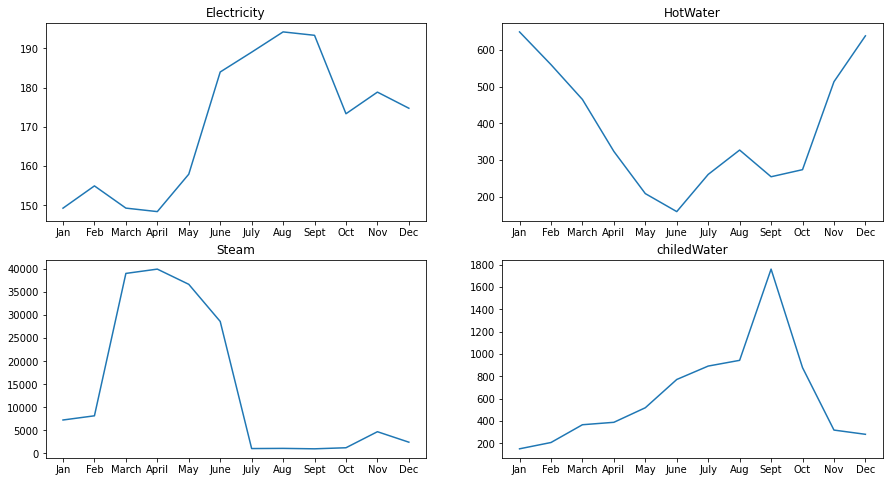

In [43]:
#plt.figure(1)
fig, axs = plt.subplots(2,2)
axs[0,0].plot(train_copy[train_copy['meter']=='Electricity'].groupby('month',sort=False)['meter_reading'].mean())
axs[0,0].set_title('Electricity')
axs[0,1].plot(train_copy[train_copy['meter']=='HotWater'].groupby('month',sort=False)['meter_reading'].mean())
axs[0,1].set_title('HotWater')
axs[1,0].plot(train_copy[train_copy['meter']=='Steam'].groupby('month',sort=False)['meter_reading'].mean())
axs[1,0].set_title('Steam')
axs[1,1].plot(train_copy[train_copy['meter']=='chiledWater'].groupby('month',sort=False)['meter_reading'].mean())
axs[1,1].set_title('chiledWater')
#for ax in axs.flat:
#    ax.set(xlabel='MONTH', ylabel='ENERGY CONSUMPTION')
plt.show()

From the above graph we an see mean energy consumption on each month for each different meter type. 

As we can see max energy consumption due to electricity has happned on the month of June, July, August and Septenber.

Max energy consumption due to hot water has happned on the month of December, January, and February.

Max energy consumption due to steam has happned on the month of March, April, May and June.

Max energy consumption due to chiledwater has happned on the month of Septenber, October.

In [54]:
''' Total area distribution as per building type for each site'''
train_copy.groupby(['site_id','primary_use'])['square_feet'].sum().unstack()

primary_use,Education,Entertainment/public assembly,Food sales and service,Healthcare,Lodging/residential,Manufacturing/industrial,Office,Other,Parking,Public services,Religious worship,Retail,Services,Technology/science,Utility,Warehouse/storage
site_id,,,,,,,,,,,,,,,,
0,49772099.0,5115856.0,NaN,NaN,40743211.0,NaN,33242998.0,5772249.0,3399408.0,NaN,NaN,9291118.0,NaN,NaN,NaN,NaN
1,35659834.0,210816.0,NaN,NaN,13694256.0,NaN,19658397.0,NaN,NaN,4707311.0,NaN,NaN,NaN,NaN,NaN,NaN
2,151147209.0,44229539.0,4259545.0,701800.0,47236649.0,NaN,62803882.0,NaN,3837643.0,15938385.0,816633.0,2951088.0,NaN,NaN,3478068.0,1267124.0
3,96008798.0,52165520.0,NaN,5864512.0,11131496.0,NaN,25443299.0,3007395.0,1967168.0,101844700.0,140512.0,1018712.0,NaN,NaN,NaN,7042304.0
4,72798299.0,8907259.0,NaN,NaN,4077122.0,NaN,NaN,NaN,4388762.0,5629823.0,NaN,NaN,NaN,3377517.0,1190000.0,NaN
5,47741040.0,18525456.0,NaN,342576.0,1449360.0,2380464.0,14739552.0,1203408.0,NaN,5261616.0,NaN,NaN,NaN,NaN,NaN,NaN
6,36847233.0,6456648.0,NaN,NaN,18772622.0,NaN,23939729.0,NaN,NaN,893280.0,NaN,NaN,NaN,NaN,NaN,NaN
7,44204648.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,25722945.0,NaN,NaN,NaN,NaN,6403739.0,10474825.0,NaN,33104551.0,NaN,NaN,NaN,NaN,NaN,188041.0


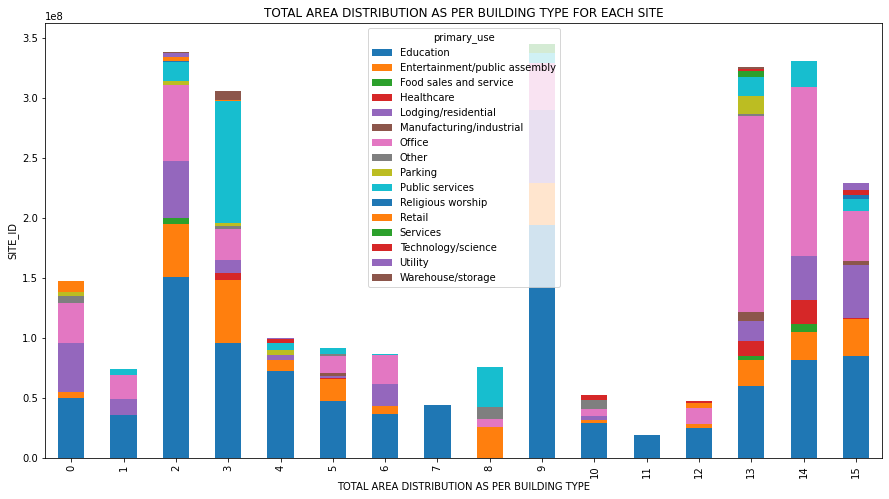

In [53]:
train_copy.groupby(['site_id','primary_use'])['square_feet'].sum().unstack().plot(kind='bar',stacked=True)
plt.title('TOTAL AREA DISTRIBUTION AS PER BUILDING TYPE FOR EACH SITE')
plt.xlabel('TOTAL AREA DISTRIBUTION AS PER BUILDING TYPE')
plt.ylabel('SITE_ID')
plt.show()

From here we can see the maximum data has come from education institute as this is the majority for most of the site. In case of site 13,max data has come from office area.

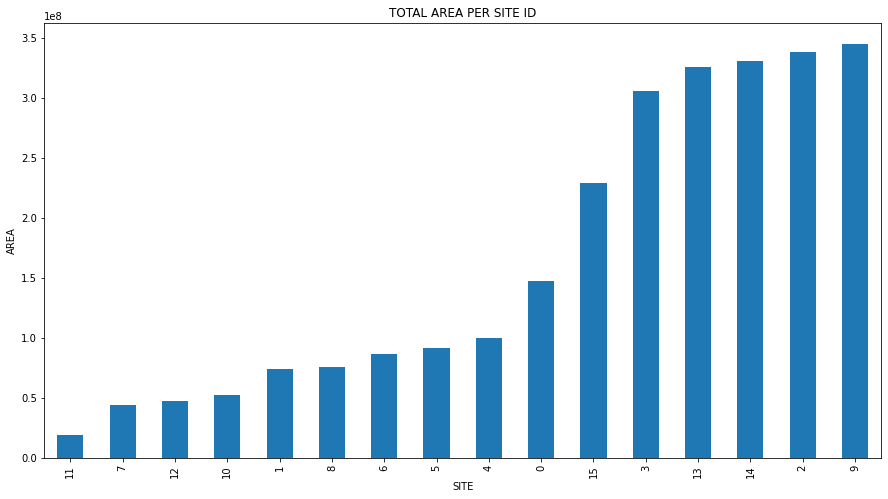

In [57]:
'''total area distribution per site'''
train_copy.groupby('site_id')['square_feet'].sum().sort_values(ascending=True).plot(kind='bar')
plt.xlabel('SITE')
plt.ylabel('AREA')
plt.title('TOTAL AREA PER SITE ID')
plt.show()

From here we can see how much area has been considered from each site to collect the data . Maximum area has been considered from site 3 and minimun area has been considered from site 11

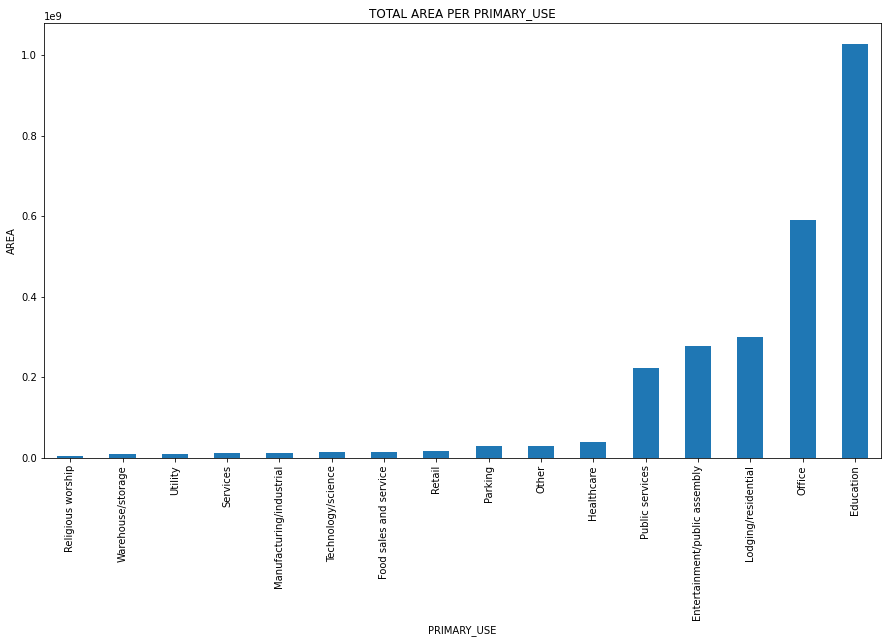

In [60]:
''' total area distribution as per building type'''
train_copy.groupby('primary_use')['square_feet'].sum().sort_values(ascending=True).plot(kind='bar')
plt.xlabel('PRIMARY_USE')
plt.ylabel('AREA')
plt.title('TOTAL AREA PER PRIMARY_USE')
plt.show()

From here we can conclude, maximum data has been taken from educational institute and the next is office area. Minimum data has been taken from religious worship.

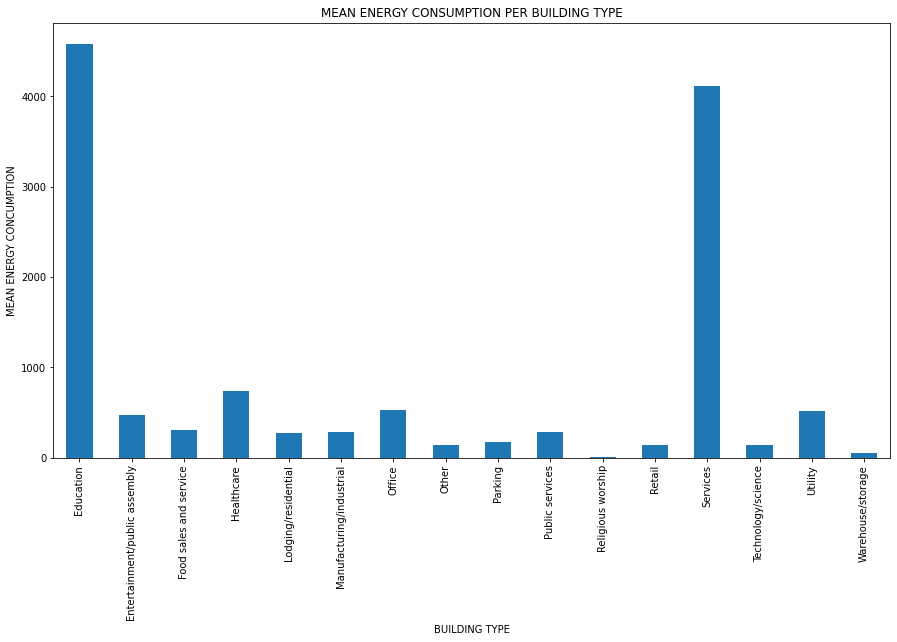

In [61]:
''' Mean energy consumption per building type'''
train_copy.groupby('primary_use')['meter_reading'].mean().plot(kind='bar')
plt.title('MEAN ENERGY CONSUMPTION PER BUILDING TYPE')
plt.xlabel('BUILDING TYPE')
plt.ylabel('MEAN ENERGY CONCUMPTION')
plt.show()

From here we can see maximum energy consumption has happend in education area and service area . Minimum energy consumption has happend in  religious worship

In [62]:
''' mean energy consumption per meter type for each different building'''
train_copy.groupby(['primary_use','meter'])['meter_reading'].median().unstack()

meter,Electricity,HotWater,Steam,chiledWater
primary_use,,,,
Education,93.75000,26.2481,217.0610,173.76800
Entertainment/public assembly,31.33000,50.2320,228.7500,147.56700
Food sales and service,72.00000,26.3764,742.4740,147.00400
Healthcare,164.77100,109.3900,950.1050,199.57150
Lodging/residential,58.75010,35.7812,125.2350,113.75100
Manufacturing/industrial,52.05900,NaN,511.7190,217.69300
Office,64.00000,79.1292,399.4140,60.97560
Other,12.50000,NaN,117.1875,83.89610
Parking,43.89400,NaN,594.0000,5.72690


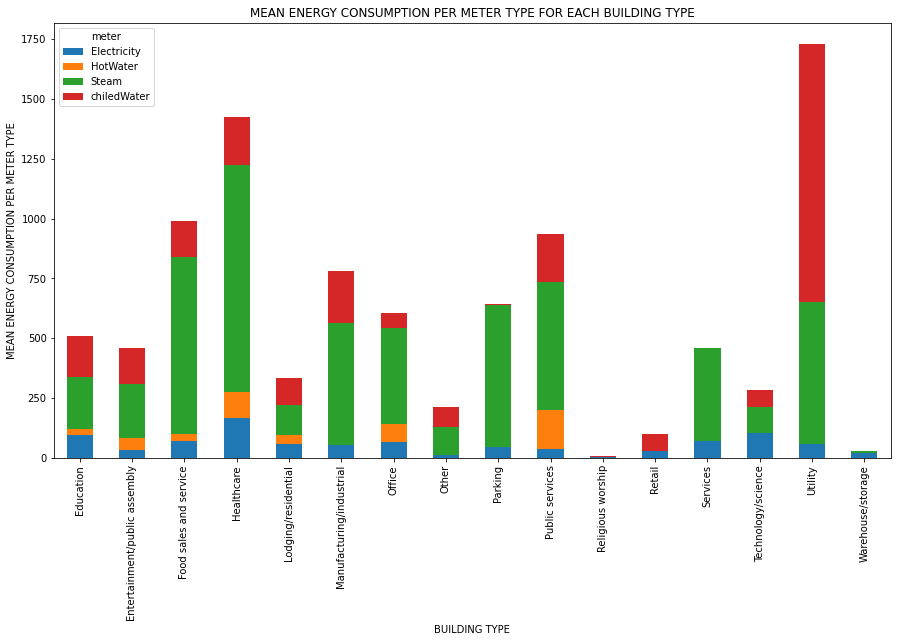

In [71]:
train_copy.groupby(['primary_use','meter'])['meter_reading'].median().unstack().plot(kind='bar',stacked=True)
plt.title('MEAN ENERGY CONSUMPTION PER METER TYPE FOR EACH BUILDING TYPE')
plt.xlabel('BUILDING TYPE')
plt.ylabel('MEAN ENERGY CONSUMPTION PER METER TYPE')
plt.show()

From here we can conclude maximum energy consumption due to electricity and steam has happend in healthcare instiute.Maximum energy consumption due to chiledwater has happend in utility area.Maximum energy consumption due to hot water has happend in public service area.

In [72]:
train_copy.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,hour,day,month,weekday
0,0,Electricity,2016-01-01,0.0,0,Education,8,2008.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0,0,1,Jan,Friday
1,1,Electricity,2016-01-01,0.0,0,Education,160,2004.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0,0,1,Jan,Friday
2,2,Electricity,2016-01-01,0.0,0,Education,0,1991.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0,0,1,Jan,Friday
3,3,Electricity,2016-01-01,0.0,0,Education,133,2002.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0,0,1,Jan,Friday
4,4,Electricity,2016-01-01,0.0,0,Education,127,1975.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0,0,1,Jan,Friday


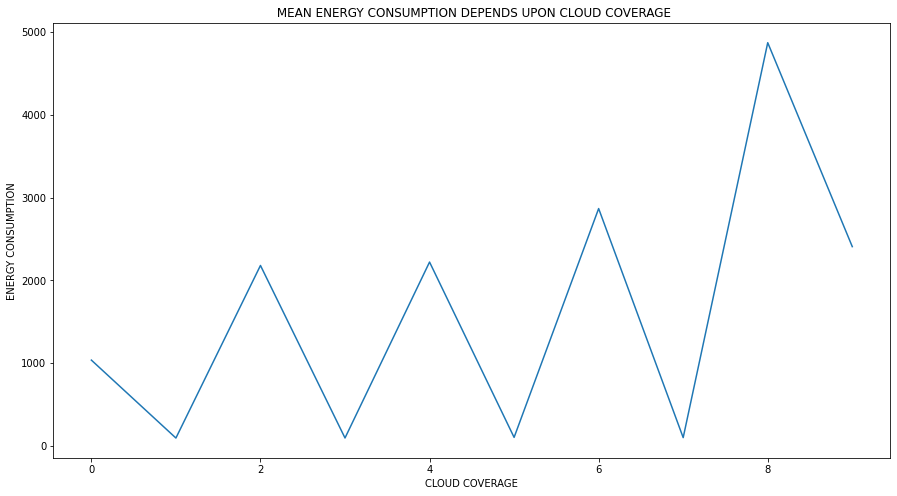

In [73]:
train_copy.groupby('cloud_coverage')['meter_reading'].mean().plot()
plt.title(' MEAN ENERGY CONSUMPTION DEPENDS UPON CLOUD COVERAGE')
plt.xlabel('CLOUD COVERAGE')
plt.ylabel('ENERGY CONSUMPTION')
plt.show()


Energy consumption has not been directly related to Cloude covereage. But Cloude covereage has an impact on air temperature as if the weather is cloudy, the air temperature become less which will help to reduce cooling load.

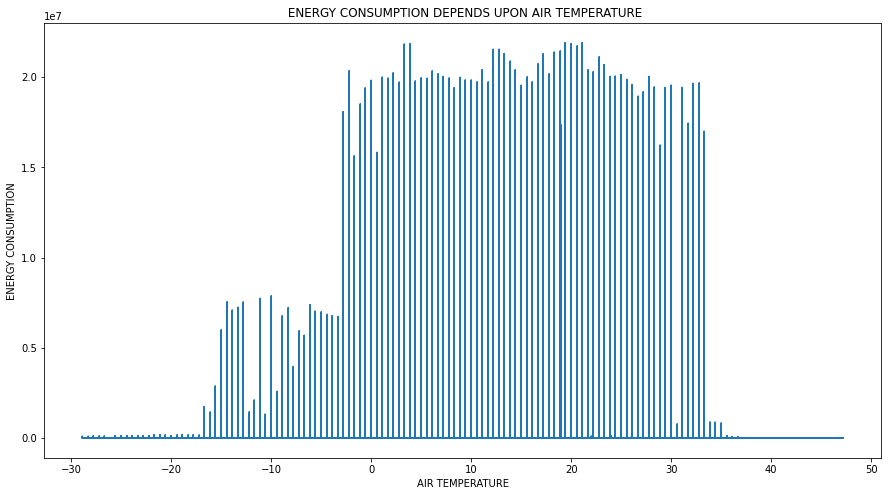

In [74]:
plt.plot(train_copy['air_temperature'],train_data['meter_reading'])
plt.title(' ENERGY CONSUMPTION DEPENDS UPON AIR TEMPERATURE')
plt.xlabel('AIR TEMPERATURE')
plt.ylabel('ENERGY CONSUMPTION')
plt.show()

From the above graph we can see the energy consumption respect to air temperature

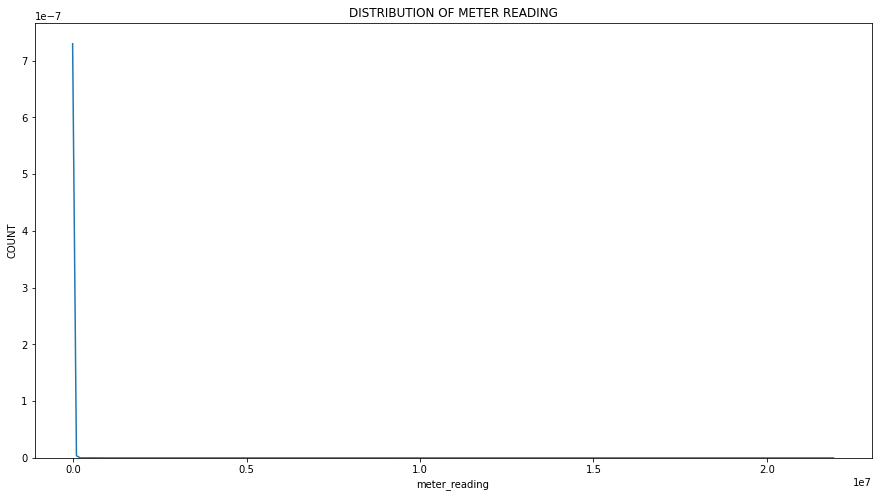

In [75]:
'''distribution of meter reading'''

sns.kdeplot(train_copy['meter_reading'])
plt.ylabel('COUNT')
plt.title('DISTRIBUTION OF METER READING')
plt.show()

From the above graph we can see the meter reading is not Gaussian distributed. So we have to do log transform to convert meter reading to Gaussian distribution

In [19]:
train_copy['meter_reading'] = np.log1p(train_copy['meter_reading'])


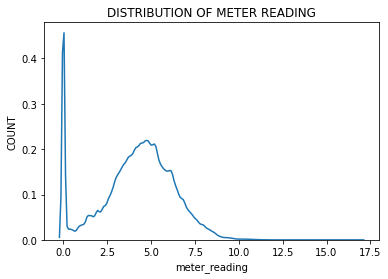

In [20]:
# https://www.kaggle.com/zeynepkurban/ashrae-great-energy-predictor-iii
''' distribution of meter reading after lof transform'''
sns.kdeplot(train_copy['meter_reading'])
plt.ylabel('COUNT')
plt.title('DISTRIBUTION OF METER READING')
plt.show()

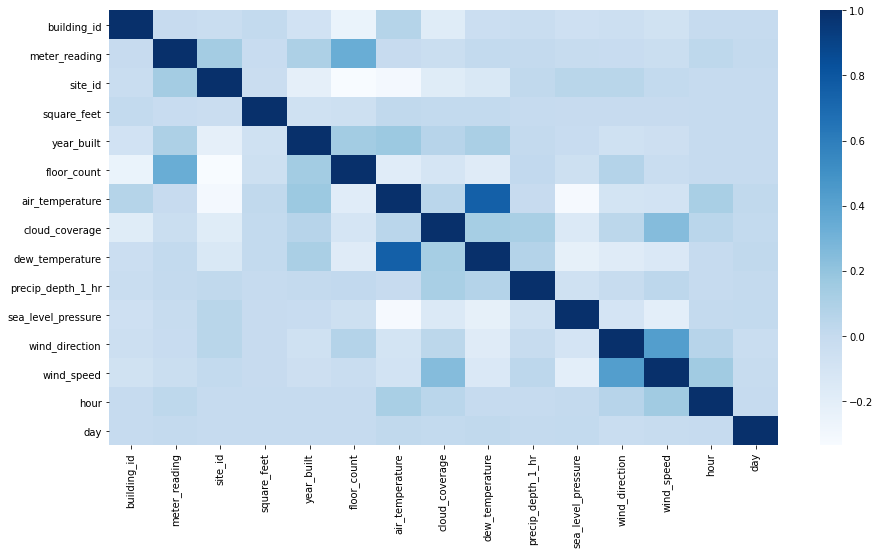

In [78]:
''' To see correlation between all features'''
sns.heatmap(train_copy.corr(),cmap='Blues')
plt.show()

From here we can see the correlation between all the featurs. we can conclude site_id,sea_level_pressure and precip_depth_1_hr have very less correlation with other features

# Missing value

# Missing value Building data

In [ ]:
building_data.isnull().sum()

site_id           0
building_id       0
primary_use       0
square_feet       0
year_built      774
floor_count    1094
dtype: int64

# Missing value weather

In [ ]:
train_copy['air_temperature'].mean()

15.987952737489769

In [ ]:
weather.isnull().sum()

site_id                   0
timestamp                 0
air_temperature          55
cloud_coverage        69173
dew_temperature         113
precip_depth_1_hr     50289
sea_level_pressure    10618
wind_direction         6268
wind_speed              304
dtype: int64

# Missing value train

In [79]:
''' missing value in the total data set'''
train_copy.isnull().sum()

building_id                  0
meter                        0
timestamp                    0
meter_reading                0
site_id                      0
primary_use                  0
square_feet                  0
year_built            12127645
floor_count           16709167
air_temperature          96658
cloud_coverage         8825365
dew_temperature         100140
precip_depth_1_hr      3749023
sea_level_pressure     1231669
wind_direction         1449048
wind_speed              143676
hour                         0
day                          0
month                        0
weekday                      0
dtype: int64

In [80]:
from prettytable import PrettyTable
from tqdm import tqdm

x = PrettyTable()

x.field_names = ["column", "Total missing value", "mean", "median"]
for i in tqdm(train_copy.columns):
  if i !='timestamp' and train_copy[i].isnull().sum() != 0:
    x.add_row([i, train_copy[i].isnull().sum(), train_copy[i].mean(), train_copy[i].median()])
print(x)

100%|██████████| 20/20 [00:05<00:00,  3.69it/s]

+--------------------+---------------------+--------------------+--------+
|       column       | Total missing value |        mean        | median |
+--------------------+---------------------+--------------------+--------+
|     year_built     |       12127645      | 1968.2767356683075 | 1969.0 |
|    floor_count     |       16709167      | 4.184848127979634  |  3.0   |
|  air_temperature   |        96658        | 15.987952737489769 |  16.7  |
|   cloud_coverage   |       8825365       | 1.9004228436531971 |  0.0   |
|  dew_temperature   |        100140       | 7.747429309915309  |  8.9   |
| precip_depth_1_hr  |       3749023       | 0.796415538714005  |  0.0   |
| sea_level_pressure |       1231669       | 1016.0854873724754 | 1016.0 |
|   wind_direction   |       1449048       | 173.01510391722684 | 180.0  |
|     wind_speed     |        143676       | 3.3775245837257293 |  3.1   |
+--------------------+---------------------+--------------------+--------+


In [21]:
''' replace nan value with mean value for all the features'''

train_copy['year_built'].fillna(train_copy['year_built'].median(),inplace  = True)
train_copy['floor_count'].fillna(train_copy['floor_count'].median(),inplace  = True)
train_copy['air_temperature'].fillna(train_copy['air_temperature'].mean(),inplace  = True)
train_copy['cloud_coverage'].fillna(train_copy['cloud_coverage'].mean(),inplace  = True)
train_copy['dew_temperature'].fillna(train_copy['dew_temperature'].mean(),inplace  = True)
train_copy['precip_depth_1_hr'].fillna(train_copy['precip_depth_1_hr'].mean(),inplace  = True)
train_copy['sea_level_pressure'].fillna(train_copy['sea_level_pressure'].mean(),inplace  = True)
train_copy['wind_direction'].fillna(train_copy['wind_direction'].mean(),inplace  = True)
train_copy['wind_speed'].fillna(train_copy['wind_speed'].mean(),inplace  = True)


In [22]:
train_copy.isnull().sum()

building_id           0
meter                 0
timestamp             0
meter_reading         0
site_id               0
primary_use           0
square_feet           0
year_built            0
floor_count           0
air_temperature       0
cloud_coverage        0
dew_temperature       0
precip_depth_1_hr     0
sea_level_pressure    0
wind_direction        0
wind_speed            0
hour                  0
day                   0
month                 0
weekday               0
dtype: int64

In [34]:
'''The shap  before removing outlier'''
train_copy.shape

(20216100, 20)

In [35]:
''' to save the train csv file for future use'''
#path = r'/content/drive/My Drive/case study1/train_final_with_outlier.csv'
train_copy.to_csv('train_final_with_outlier.csv',index=False)

# Remove Outlier

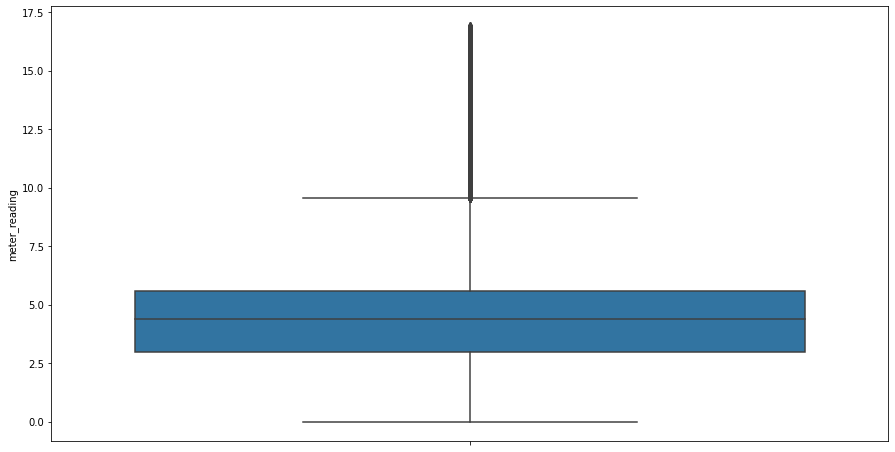

In [ ]:
sns.boxplot(y=train_copy['meter_reading'])
plt.show()

From the above boxplot we can conclude, there are lots of outlier present in the dataset which we need to remove because the evaluation metric is Root Mean Squared Logarithmic Error which is outlier sensetive.

In [ ]:
train_copy['meter_reading'].describe()

count    2.021610e+07
mean     4.145766e+00
std      2.146220e+00
min      0.000000e+00
25%      2.960105e+00
50%      4.379210e+00
75%      5.594652e+00
max      1.690221e+01
Name: meter_reading, dtype: float64

In [ ]:
''' to see the values in between 90 percentile to 100 persentile'''
for i in range (90,101,1):
  
  print('{0}percentile value={1}'.format(i,np.percentile(train_copy['meter_reading'].values, i)))


90percentile value=6.688350977949746
91percentile value=6.799055862058796
92percentile value=6.909543678841354
93percentile value=7.044137603834646
94percentile value=7.196956197403187
95percentile value=7.366672682490307
96percentile value=7.571669304271807
97percentile value=7.824445930877619
98percentile value=8.137252603425853
99percentile value=8.603411253815043
100percentile value=16.902211829285342


From above we can see the increment of meter reading from 90 percentile to 99 percentile almost linear.But the value increased almost to double from 99 percentile to 100 percentile which indicates there is outlier in the dataset

In [ ]:
''' Find out the outlier'''
from numpy import percentile
#https://machinelearningmastery.com/how-to-use-statistics-to-identify-outliers-in-data/
q25, q75 = percentile(train_copy['meter_reading'].values, 25), percentile(train_copy['meter_reading'].values, 75)
iqr = q75 - q25
print(iqr)
cut_off = iqr * 1.5
lower, upper = q25 - cut_off, q75 + cut_off
outliers = [x for x in train_copy['meter_reading'].values if x < lower or x > upper]
print('Identified outliers: %d' % len(outliers))
outliers_removed = [x for x in train_copy['meter_reading'].values if x >= lower and x <= upper]
print('Non-outlier observations: %d' % len(outliers_removed))
outlier_index=[]
for index,value in enumerate(train_copy['meter_reading'].values):
  if value < lower or value > upper:
    outlier_index.append(index)
print('the shape of index of outlier',len(outlier_index))

2.634546802368117
Identified outliers: 62648
Non-outlier observations: 20153452
the shape of index of outlier 62648


From the above we can see there are 62648 nos of data which identify as outlier

In [ ]:
'''Remove outlier'''
# https://stackoverflow.com/questions/14661701/how-to-drop-a-list-of-rows-from-pandas-dataframe
indexes_to_keep = set(range(train_copy.shape[0])) - set(outlier_index)
train_copy_sliced = train_copy.take(list(indexes_to_keep))

In [ ]:
'''The shap after removing outlier'''
train_copy_sliced.shape

(20153452, 19)

In [ ]:
''' to save the train csv file for future use'''
path = r'/content/drive/My Drive/case study1/train_final.csv'
train_copy_sliced.to_csv(path_or_buf=path,index=False)

# Test data preparation



In [25]:
#path = r'/content/drive/My Drive/case study1/test.csv'
test = pd.read_csv('test.csv')
test.head()

,row_id,building_id,meter,timestamp
0,0,0,0,2017-01-01 00:00:00
1,1,1,0,2017-01-01 00:00:00
2,2,2,0,2017-01-01 00:00:00
3,3,3,0,2017-01-01 00:00:00
4,4,4,0,2017-01-01 00:00:00


In [26]:
test.shape

(41697600, 4)

In [27]:
#path = r'/content/drive/My Drive/case study1/weather_test.csv'
weather_test = pd.read_csv('weather_test.csv')
weather_test.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2017-01-01 00:00:00,17.8,4.0,11.7,NaN,1021.4,100.0,3.6
1,0,2017-01-01 01:00:00,17.8,2.0,12.8,0.0,1022.0,130.0,3.1
2,0,2017-01-01 02:00:00,16.1,0.0,12.8,0.0,1021.9,140.0,3.1
3,0,2017-01-01 03:00:00,17.2,0.0,13.3,0.0,1022.2,140.0,3.1
4,0,2017-01-01 04:00:00,16.7,2.0,13.3,0.0,1022.3,130.0,2.6


In [28]:
new_test=pd.merge(test,building_data,how="left",on='building_id')
test_data=pd.merge(new_test,weather_test,how="left",on=['site_id','timestamp'])
test_data.head()

,row_id,building_id,meter,timestamp,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,0,2017-01-01 00:00:00,0,Education,7432,2008.0,NaN,17.8,4.0,11.7,NaN,1021.4,100.0,3.6
1,1,1,0,2017-01-01 00:00:00,0,Education,2720,2004.0,NaN,17.8,4.0,11.7,NaN,1021.4,100.0,3.6
2,2,2,0,2017-01-01 00:00:00,0,Education,5376,1991.0,NaN,17.8,4.0,11.7,NaN,1021.4,100.0,3.6
3,3,3,0,2017-01-01 00:00:00,0,Education,23685,2002.0,NaN,17.8,4.0,11.7,NaN,1021.4,100.0,3.6
4,4,4,0,2017-01-01 00:00:00,0,Education,116607,1975.0,NaN,17.8,4.0,11.7,NaN,1021.4,100.0,3.6


In [29]:
'''make a copy of train data and add features'''
test_copy = test_data.copy()

In [ ]:
'''Dropping Timestamp and extracting other features from timestamp'''
test_copy.drop(columns=['timestamp'],inplace=True,axis=1)
test_copy.head()

,row_id,building_id,meter,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,0,0,Education,7432,2008.0,NaN,17.8,4.0,11.7,NaN,1021.4,100.0,3.6
1,1,1,0,0,Education,2720,2004.0,NaN,17.8,4.0,11.7,NaN,1021.4,100.0,3.6
2,2,2,0,0,Education,5376,1991.0,NaN,17.8,4.0,11.7,NaN,1021.4,100.0,3.6
3,3,3,0,0,Education,23685,2002.0,NaN,17.8,4.0,11.7,NaN,1021.4,100.0,3.6
4,4,4,0,0,Education,116607,1975.0,NaN,17.8,4.0,11.7,NaN,1021.4,100.0,3.6


In [30]:
test_copy.shape

(41697600, 16)

In [31]:
''' add new features'''
test_copy['timestamp']=pd.to_datetime(test_copy['timestamp'])
test_copy['hour']=np.uint8(test_copy['timestamp'].dt.hour)
test_copy['day']=np.uint8(test_copy['timestamp'].dt.day)
test_copy['month']=np.uint8(test_copy['timestamp'].dt.month)
test_copy['weekday']=np.uint8(test_copy['timestamp'].dt.dayofweek)
''' change the datatype to reduce memory usage'''
test_copy['building_id']=np.uint8(test_copy['building_id'])
test_copy['meter']=np.uint8(test_copy['meter'])
test_copy['site_id']=np.uint8(test_copy['site_id'])
test_copy['square_feet']=np.uint8(test_copy['square_feet'])

test_copy.head()

,row_id,building_id,meter,timestamp,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,hour,day,month,weekday
0,0,0,0,2017-01-01,0,Education,8,2008.0,NaN,17.8,4.0,11.7,NaN,1021.4,100.0,3.6,0,1,1,6
1,1,1,0,2017-01-01,0,Education,160,2004.0,NaN,17.8,4.0,11.7,NaN,1021.4,100.0,3.6,0,1,1,6
2,2,2,0,2017-01-01,0,Education,0,1991.0,NaN,17.8,4.0,11.7,NaN,1021.4,100.0,3.6,0,1,1,6
3,3,3,0,2017-01-01,0,Education,133,2002.0,NaN,17.8,4.0,11.7,NaN,1021.4,100.0,3.6,0,1,1,6
4,4,4,0,2017-01-01,0,Education,127,1975.0,NaN,17.8,4.0,11.7,NaN,1021.4,100.0,3.6,0,1,1,6


In [32]:
test_copy.shape

(41697600, 20)

In [33]:
''' to save the test csv file for future use'''
#path = r'/content/drive/My Drive/case study1/test_final.csv'
test_copy.to_csv('test_final.csv',index=False)